<a href="https://colab.research.google.com/github/AHamamd150/Zewail-city/blob/main/QML_DNN_Angle_Amplitude_Embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pennylane --upgrade

In [28]:
import os # To use the system comands in python
import matplotlib.pyplot as plt # plotting library
import numpy as np  #Numerical python liberary
import pandas as pd #Data handeling python module 
plt.style.use('seaborn')
import pennylane as qml 
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer
import matplotlib.pyplot as plt

In [29]:
!git clone https://github.com/AHamamd150/Zewail-city.git


fatal: destination path 'Zewail-city' already exists and is not an empty directory.


In [30]:
columns=['dr','met','ptj1','etaj1','ptj2','etaj2','ptZ','etaZ']
bkg=pd.DataFrame(np.load('Zewail-city/data/bkg.npz',allow_pickle=True)['arr_0'].T,columns=columns)
sig=pd.DataFrame(np.load('Zewail-city/data/Signal.npz',allow_pickle=True)['arr_0'].T,columns=columns)

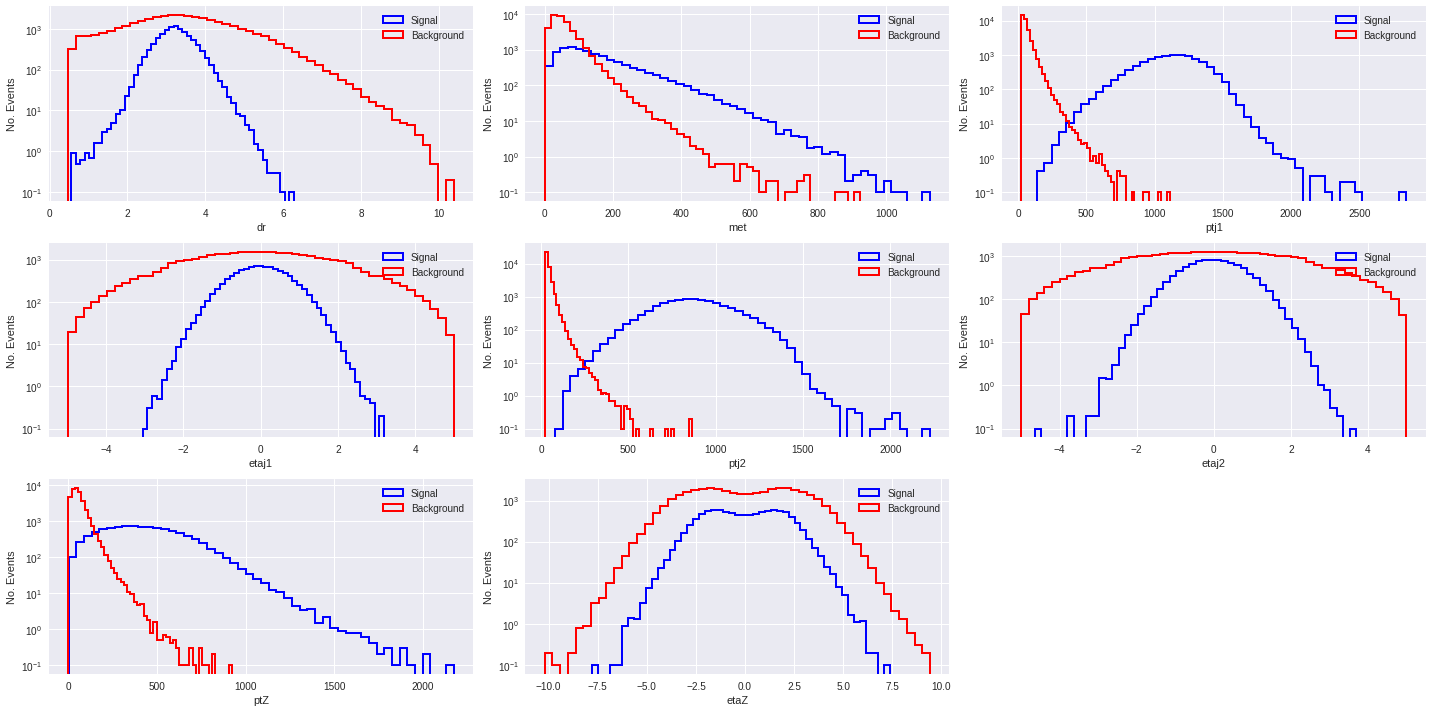

In [ ]:
signal_weight = 0.1 #weight of the signal events
bkg_weight = 0.1 # Weight of the background events
##########
fig= plt.figure(figsize=(20,10))
fig.subplots_adjust(hspace=1, wspace=1)
for q in range(8):
    y= fig.add_subplot(3,3,q+1)
    y.hist(sig.iloc[:,q],bins=50,fill=False,histtype='step',weights=np.ones(len((sig.iloc[:,q])))*signal_weight,log=True,label='Signal',linewidth=2,color='b');
    y.hist(bkg.iloc[:,q],bins=50,fill=False,histtype='step',weights=np.ones(len((bkg.iloc[:,q])))*bkg_weight,log=True,label='Background',linewidth=2,color='r');
    y.set_xlabel(columns[q]);
    y.set_ylabel('No. Events');
    plt.legend(loc='best',fontsize=10);
    plt.tight_layout()


# Create the labels for both events: 
* Signal events = 1 
* Background events = -1

In [31]:
sig['label']=np.ones(sig.shape[0])
bkg['label']=np.ones(bkg.shape[0])*-1

In [32]:
df = pd.concat([sig[:100],bkg[:100]],ignore_index=True) 

# Split the data into train sample and test sample

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,0:4],df.iloc[:,-1],stratify=df.iloc[:,-1],test_size=0.2)

In [34]:
print('train sample shape= ',X_train.shape,' and test sample shape= ',X_test.shape)
print('train label shape= ',y_train.shape,'\t and test label shape= ',y_test.shape)

train sample shape=  (160, 4)  and test sample shape=  (40, 4)
train label shape=  (160,) 	 and test label shape=  (40,)


In [35]:
from sklearn.preprocessing import StandardScaler
Sc = StandardScaler()
X_train = Sc.fit_transform(X_train)
X_test = Sc.transform(X_test)

# Amplitude embedding

In [36]:
# Four features for 4 qubits
dev = qml.device("default.qubit",shots=1000, wires=4)
def layer(W):
    
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=2)
    qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=3)

    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[3, 0])

#define the circuit after basis embedding 
@qml.qnode(dev)
def circuit(weights, x):
    qml.AmplitudeEmbedding(features=x, wires=range(4), pad_with=0.,normalize=True)
    #qml.AngleEmbedding(features=x, wires=range(4), rotation='Z')
    #qml.state()
    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0))

In [37]:
X = np.array(X_train, requires_grad=False)
Y = np.array(y_train, requires_grad=False)

In [38]:
num_qubits = 4
num_layers = 3
weights_init = 0.0 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)#Initialize the weights

/usr/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The datapath rcparam was deprecated in Matplotlib 3.2.1 and will be removed two minor releases later.
  self[key] = other[key]
/usr/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/usr/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


<Figure size 2000x2000 with 0 Axes>

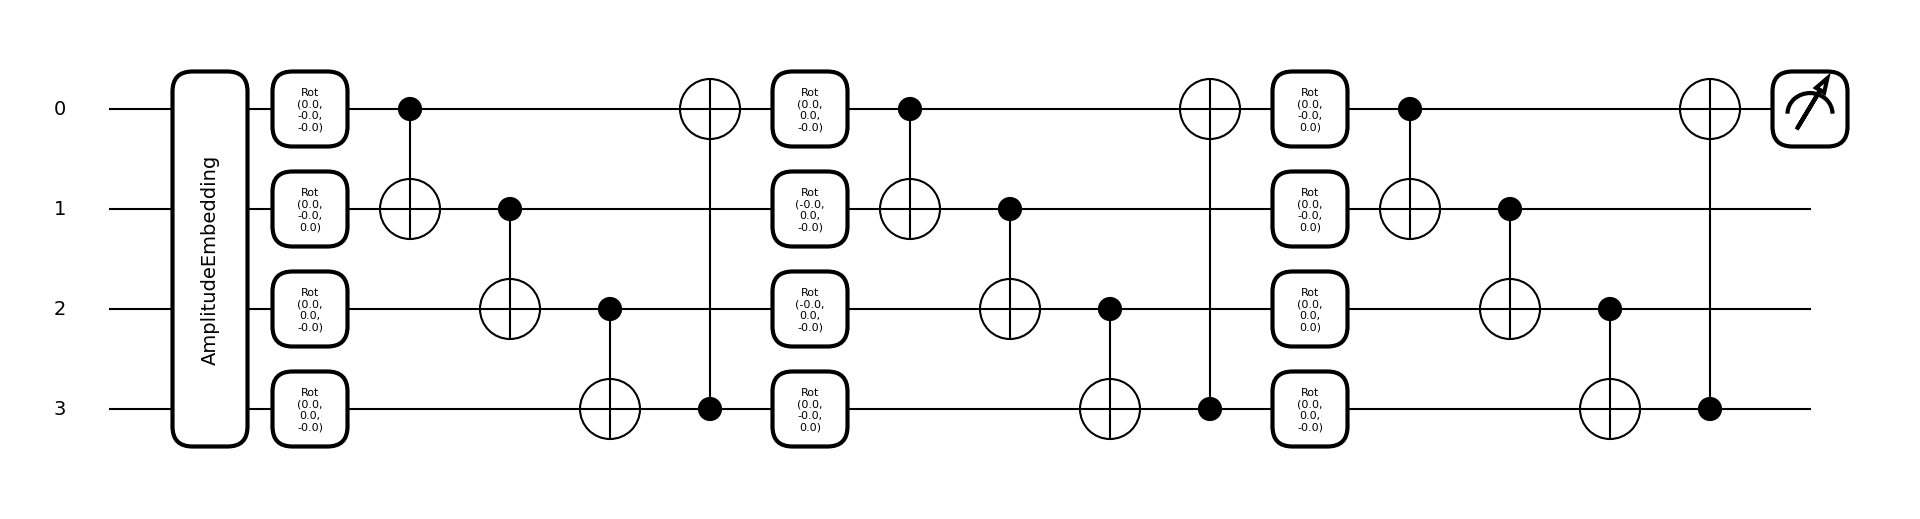

In [ ]:
qml.drawer.use_style('default');
plt.figure(figsize=(20,20));
fig, ax = qml.draw_mpl(circuit, decimals=1)(weights_init,X);
plt.show();

In [39]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss
#define the cost to be minimized
def cost(weights,X, Y):
    predictions = [circuit(weights, x) for x in X]
    return square_loss(Y, predictions) #returns the mean squared loss     

# Train the model with amplitude embedding 

In [40]:
#Train the model

epoch = 20 
weights = weights_init
opt = AdamOptimizer(0.1)
batch_size = 5
loss2 = []
for q in range(epoch):
    index = np.random.randint(0, len(X), (batch_size,)) #catch random features from the batch size 
    X_batch = X[index]
    Y_batch = Y[index]
    weights,_, _ = opt.step(cost, weights, X_batch, Y_batch)
    predictions = [np.sign(circuit(weights, x)) for x in X]
    #Val = [np.sign(circuit(weights, x)) for x in X_val] #validation set if needed
    loss2.append(cost(weights,X, Y))
    print("Epoch: {}  |   Cost: {:0.7f} ".format(q + 1, cost(weights,X, Y)))

Epoch: 1  |   Cost: 1.9274042 
Epoch: 2  |   Cost: 1.7659326 
Epoch: 3  |   Cost: 1.5858404 
Epoch: 4  |   Cost: 1.3606190 
Epoch: 5  |   Cost: 1.1674200 
Epoch: 6  |   Cost: 1.0000616 
Epoch: 7  |   Cost: 0.8913743 
Epoch: 8  |   Cost: 0.8269869 
Epoch: 9  |   Cost: 0.8203524 
Epoch: 10  |   Cost: 0.7948110 
Epoch: 11  |   Cost: 0.7633191 
Epoch: 12  |   Cost: 0.7326044 
Epoch: 13  |   Cost: 0.7123503 
Epoch: 14  |   Cost: 0.7056211 
Epoch: 15  |   Cost: 0.6985576 
Epoch: 16  |   Cost: 0.6973318 
Epoch: 17  |   Cost: 0.7128452 
Epoch: 18  |   Cost: 0.7166102 
Epoch: 19  |   Cost: 0.7104599 
Epoch: 20  |   Cost: 0.6969969 


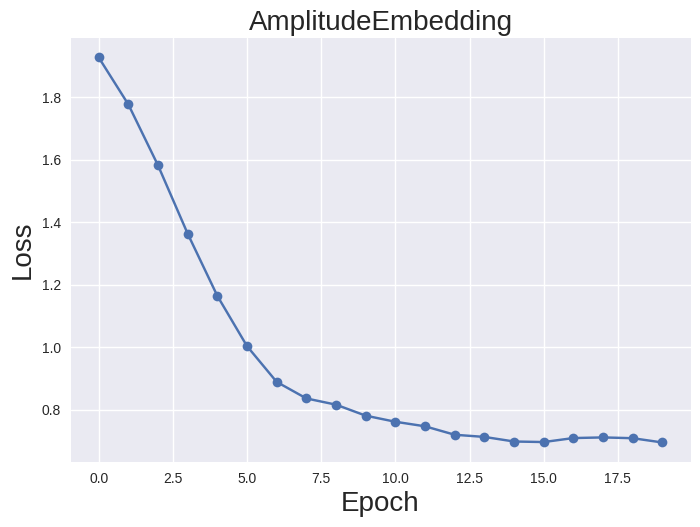

In [41]:
plt.plot(loss2,'-o');
plt.xlabel('Epoch',fontsize=20);
plt.ylabel('Loss',fontsize=20);
plt.title('AmplitudeEmbedding',fontsize=20);

# Do some predictions

In [ ]:
for i in range(10):
    print('Y_prediction= {} ,   Y_True= {}'.format(circuit(weights,X_test[i]),np.array(y_test)[i]))

Y_prediction= -0.354 ,   Y_True= -1.0
Y_prediction= -0.072 ,   Y_True= -1.0
Y_prediction= 0.118 ,   Y_True= 1.0
Y_prediction= -0.328 ,   Y_True= -1.0
Y_prediction= 0.122 ,   Y_True= 1.0
Y_prediction= -0.21 ,   Y_True= -1.0
Y_prediction= 0.17 ,   Y_True= 1.0
Y_prediction= 0.352 ,   Y_True= 1.0
Y_prediction= 0.092 ,   Y_True= 1.0
Y_prediction= 0.04 ,   Y_True= 1.0


# Angle embedding 

In [42]:
# Four features for 4 qubits
dev1 = qml.device("default.qubit",shots=1000, wires=4)

#define the circuit after basis embedding 
@qml.qnode(dev1)
def circuit1(weights, x):
    qml.AngleEmbedding(features=x, wires=range(4), rotation='Z')
    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0))

/usr/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The datapath rcparam was deprecated in Matplotlib 3.2.1 and will be removed two minor releases later.
  self[key] = other[key]
/usr/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/usr/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


<Figure size 2000x2000 with 0 Axes>

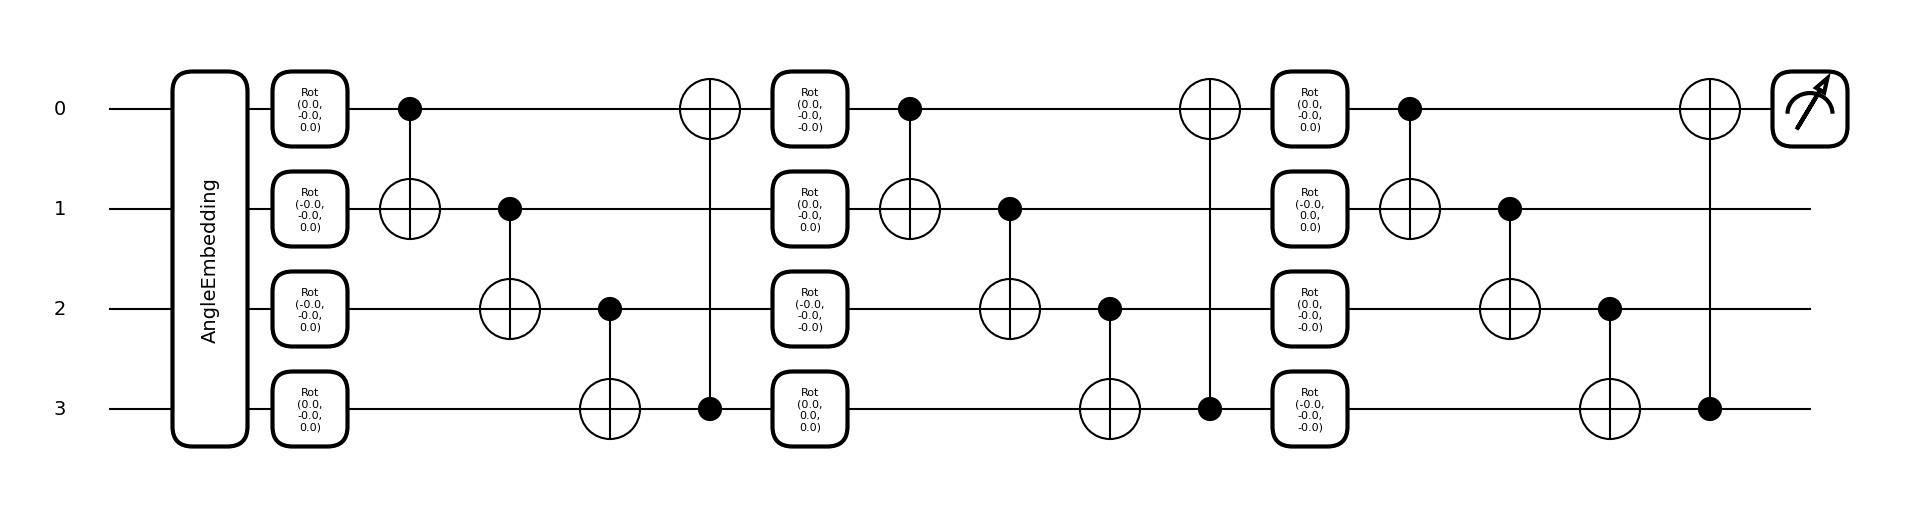

In [ ]:
qml.drawer.use_style('default');
plt.figure(figsize=(20,20));
fig, ax = qml.draw_mpl(circuit1, decimals=1)(weights_init,X);
plt.show();

In [43]:
#define the cost to be minimized
def cost1(weights,X, Y):
    predictions = [circuit1(weights, x) for x in X]
    return square_loss(Y, predictions) #returns the mean squared loss     

In [44]:
#Train the model

epoch = 20 
weights = weights_init
opt = AdamOptimizer(0.1)
batch_size = 5
loss1 = []
for q in range(epoch):
    index = np.random.randint(0, len(X), (batch_size,)) #catch random features from the batch size 
    X_batch = X[index]
    Y_batch = Y[index]
    weights,_, _ = opt.step(cost1, weights, X_batch, Y_batch)
    predictions = [np.sign(circuit1(weights, x)) for x in X]
    #Val = [np.sign(circuit(weights, x)) for x in X_val] #validation set if needed
    loss1.append(cost1(weights,X, Y))
    print("Epoch: {}  |   Cost: {:0.7f} ".format(q + 1, cost1(weights,X, Y)))

Epoch: 1  |   Cost: 1.9340291 
Epoch: 2  |   Cost: 1.7656816 
Epoch: 3  |   Cost: 1.5230631 
Epoch: 4  |   Cost: 1.2741315 
Epoch: 5  |   Cost: 1.0904255 
Epoch: 6  |   Cost: 1.0187920 
Epoch: 7  |   Cost: 1.0129091 
Epoch: 8  |   Cost: 1.0510503 
Epoch: 9  |   Cost: 1.0700172 
Epoch: 10  |   Cost: 1.0576594 
Epoch: 11  |   Cost: 1.0045190 
Epoch: 12  |   Cost: 1.0104539 
Epoch: 13  |   Cost: 1.0152282 
Epoch: 14  |   Cost: 1.0284085 
Epoch: 15  |   Cost: 1.0444674 
Epoch: 16  |   Cost: 1.0463160 
Epoch: 17  |   Cost: 1.0263538 
Epoch: 18  |   Cost: 1.0039300 
Epoch: 19  |   Cost: 0.9983561 
Epoch: 20  |   Cost: 1.0291620 


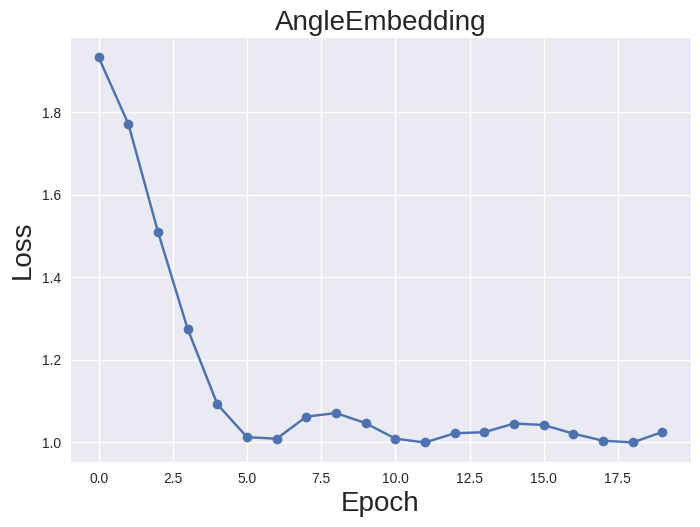

In [46]:
plt.plot(loss1,'-o');
plt.xlabel('Epoch',fontsize=20);
plt.ylabel('Loss',fontsize=20);
plt.title('AngleEmbedding',fontsize=20);

# Expressive power of repeated data encoding arXiv:2008.08605v2 

In [54]:
# Four features for 4 qubits
dev2 = qml.device("default.qubit",shots=1000, wires=4)

#define the circuit after basis embedding 
@qml.qnode(dev2)
def circuit2(weights, x):
    
    for W in weights:
        qml.AngleEmbedding(features=x, wires=range(4), rotation='Z')
        layer(W)

    return qml.expval(qml.PauliZ(0))

/usr/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The datapath rcparam was deprecated in Matplotlib 3.2.1 and will be removed two minor releases later.
  self[key] = other[key]
/usr/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/usr/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


<Figure size 2000x2000 with 0 Axes>

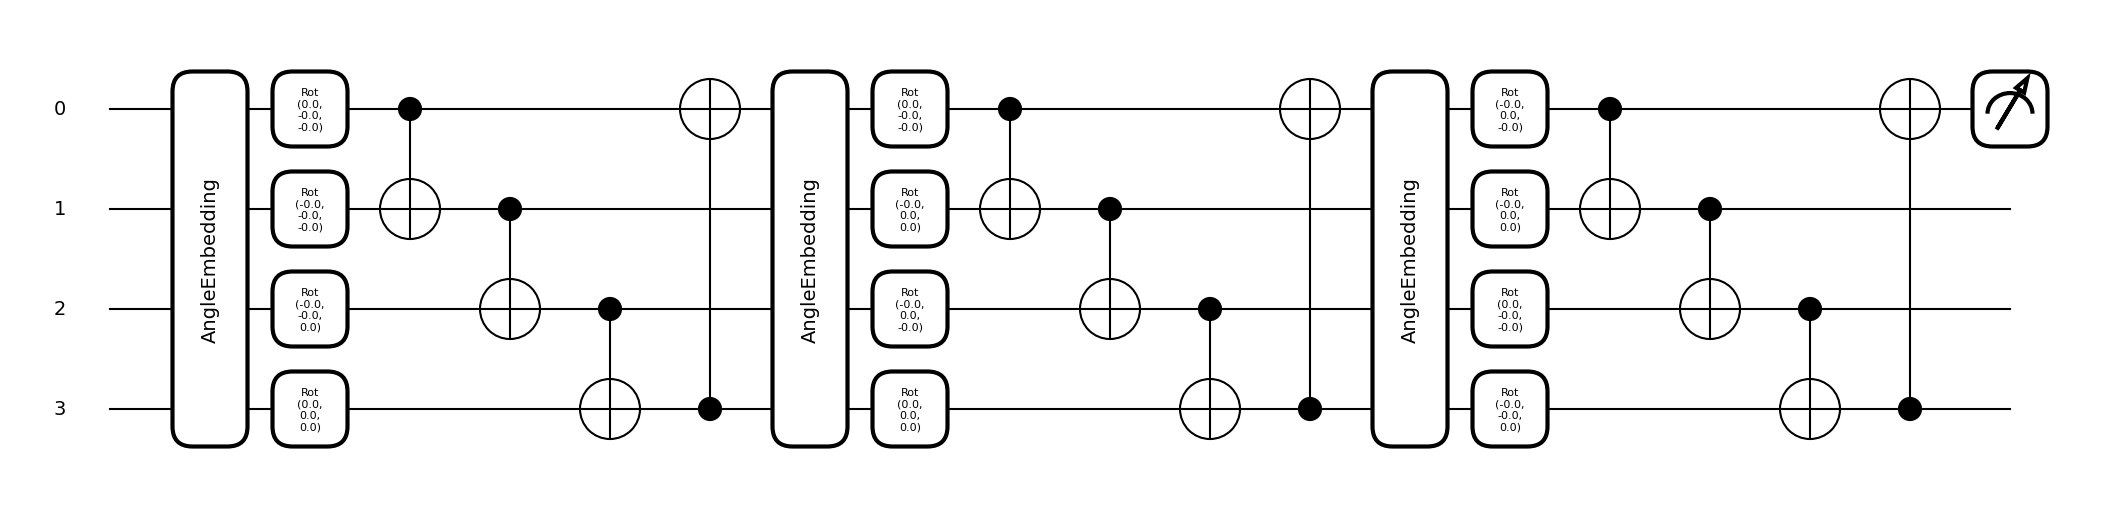

In [55]:
qml.drawer.use_style('default');
plt.figure(figsize=(20,20));
fig, ax = qml.draw_mpl(circuit2, decimals=1)(weights_init,X);
plt.show();

In [62]:
#define the cost to be minimized
def cost2(weights,X, Y):
    predictions = [circuit2(weights, x) for x in X]
    return square_loss(Y, predictions) #returns the mean squared loss  

In [63]:
#Train the model

epoch = 20 
weights = weights_init
opt = AdamOptimizer(0.1)
batch_size = 5
loss = []
for q in range(epoch):
    index = np.random.randint(0, len(X), (batch_size,)) #catch random features from the batch size 
    X_batch = X[index]
    Y_batch = Y[index]
    weights,_, _ = opt.step(cost, weights, X_batch, Y_batch)
    predictions = [np.sign(circuit2(weights, x)) for x in X]
    #Val = [np.sign(circuit(weights, x)) for x in X_val] #validation set if needed
    loss.append(cost2(weights,X, Y))
    print("Epoch: {}  |   Cost: {:0.7f} ".format(q + 1, cost2(weights,X, Y)))

Epoch: 1  |   Cost: 1.9313753 
Epoch: 2  |   Cost: 1.7871245 
Epoch: 3  |   Cost: 1.5734605 
Epoch: 4  |   Cost: 1.3271677 
Epoch: 5  |   Cost: 1.1297965 
Epoch: 6  |   Cost: 0.9747178 
Epoch: 7  |   Cost: 0.8595903 
Epoch: 8  |   Cost: 0.7938767 
Epoch: 9  |   Cost: 0.7301124 
Epoch: 10  |   Cost: 0.6757091 
Epoch: 11  |   Cost: 0.6496949 
Epoch: 12  |   Cost: 0.6253493 
Epoch: 13  |   Cost: 0.6017983 
Epoch: 14  |   Cost: 0.5933761 
Epoch: 15  |   Cost: 0.5718408 
Epoch: 16  |   Cost: 0.5585242 
Epoch: 17  |   Cost: 0.5549968 
Epoch: 18  |   Cost: 0.5485862 
Epoch: 19  |   Cost: 0.5362631 
Epoch: 20  |   Cost: 0.5320418 


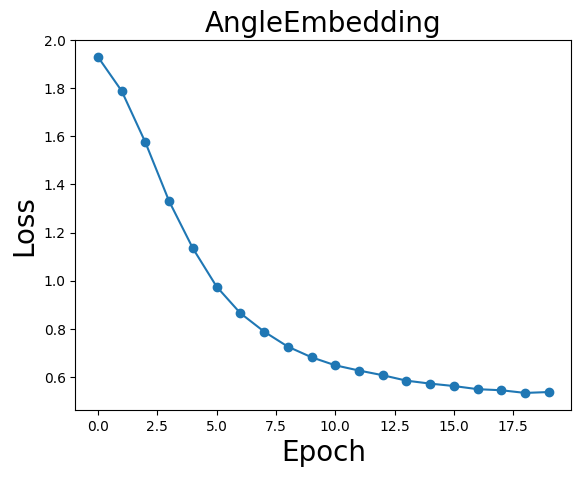

In [64]:
plt.plot(loss,'-o');
plt.xlabel('Epoch',fontsize=20);
plt.ylabel('Loss',fontsize=20);
plt.title('AngleEmbedding',fontsize=20);

###### 

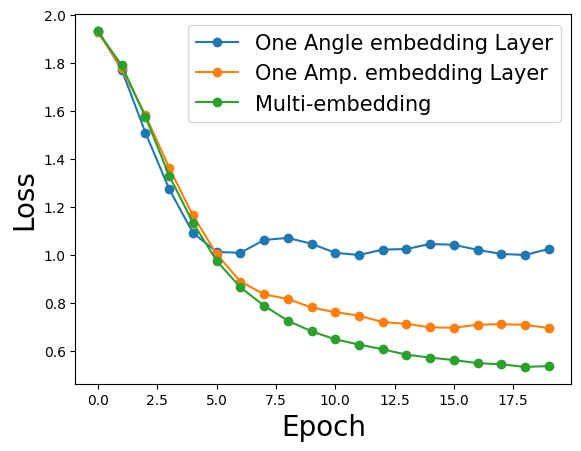

In [65]:

plt.plot(loss1,'-o',label='One Angle embedding Layer');
plt.plot(loss2,'-o',label='One Amp. embedding Layer');
plt.plot(loss,'-o',label='Multi-embedding');
plt.xlabel('Epoch',fontsize=20);
plt.ylabel('Loss',fontsize=20);
plt.legend(fontsize=15);